In [1]:
import os, requests
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras import layers 
from tensorflow.keras import Model
from tensorflow.keras.models import load_model, Sequential
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet101




In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
BUCKET = 3
IMAGE_SIZE = (224, 224)
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 64

In [3]:
gdrive_dir = "/content/drive/MyDrive"
working_dir = os.path.join(gdrive_dir, "CS3244 Project")
data_dir = os.path.join(working_dir, "landmarks/local")
model_root_dir = os.path.join(working_dir, "models/KhengHun")


In [ ]:
print('number of local labels:', len(os.listdir(data_dir)))

number of local labels: 11


In [9]:
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, interpolation="bilinear")

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255, 
    validation_split = VALIDATION_SPLIT,
    rotation_range = 30,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.1,
    brightness_range = [0.9,1.1],
    fill_mode = 'nearest'
)
train_generator = train_datagen.flow_from_directory(
    data_dir,
    subset = "training", 
    shuffle = True, 
    target_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
)

validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split = VALIDATION_SPLIT
)
validation_generator = validation_datagen.flow_from_directory(
    data_dir,
    subset = "validation", 
    shuffle = False, 
    target_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = 'categorical'
)

Found 3650 images belonging to 11 classes.
Found 909 images belonging to 11 classes.


In [ ]:
#resnet_model = ResNet101();

In [ ]:
#resnet_model.summary()

In [ ]:
last_layer = resnet_model.get_layer("predictions")
last_output = last_layer.output
x = layers.Flatten()(last_output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.2)(x)
#x = tf.keras.layers.Dense(n_units, activation=tf.keras.layers.LeakyReLU(alpha=0.01))(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization(momentum=0.95, name="batch_norm_pre-output")(x)
x = layers.Dense(11, activation='softmax')(x)
model = Model(resnet_model.input, x)



In [ ]:
model.summary()

In [4]:
load_model_dir = os.path.join(model_root_dir, "finallocal6")
model = tf.keras.models.load_model(load_model_dir)

In [ ]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(lr=0.001),
    metrics = ['accuracy']
)

steps_per_epoch = int(train_generator.samples / BATCH_SIZE)
validation_steps = int(validation_generator.samples / BATCH_SIZE)

print("Steps per epoch:", steps_per_epoch)
print("Validation steps:", validation_steps)

Steps per epoch: 57
Validation steps: 14


In [ ]:
model.summary()


In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs = 20,
    validation_data = validation_generator,
    validation_steps = validation_steps
)

save_model_dir = os.path.join(model_root_dir, "finallocal6")
model.save(save_model_dir)

df = pd.DataFrame(history.history)
hist_dir = os.path.join(model_root_dir, "history/finallocal6")
df.to_csv(hist_dir)



In [ ]:
df = pd.DataFrame(history.history)
hist_dir = os.path.join(model_root_dir, "history/l3history")
df.to_csv(hist_dir)

In [ ]:
model.summary()

Text(0.5, 1.0, 'Training and validation loss')

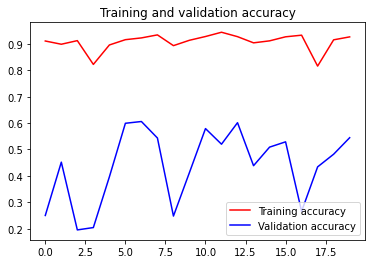

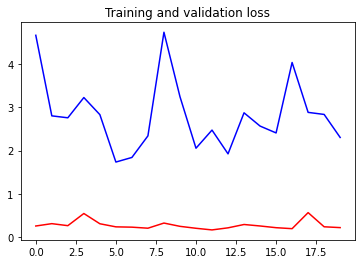

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')

In [12]:
url = "https://www.japan-guide.com/g20/3201_01.jpg"
#url = "https://www.visitsingapore.com/see-do-singapore/recreation-leisure/viewpoints/merlion-park/_jcr_content/par-carousel/carousel_detailpage/carousel/item_2.thumbnail.carousel-img.740.416.jpg"
#url = "https://www.visitsingapore.com/see-do-singapore/nature-wildlife/parks-gardens/gardens-by-the-bay/_jcr_content/par/mobile_21_content_sl/sliderccpar1/content_img_insta/content/item_2.thumbnail.image-path.350.197.jpg"
# url = "https://www.businesstimes.com.sg/sites/default/files/styles/large_popup/public/image/2020/07/21/Singapore%20Flyer%20and%20skyline%20-%20ST%20file.jpg?itok=1y0m-Kxq"


try:
  image_data = requests.get(url, stream=True).raw
except Exception as e:
  print('Warning: Could not download image from %s' % url)
  print('Error: %s' %e)
  raise

try:
  pil_image = Image.open(image_data)
except Exception as e:
  print('Warning: Failed to parse image')
  print('Error: %s' %e)
  raise

try:
  img = pil_image.convert('RGB').resize(IMAGE_SIZE)
except:
  print('Warning: Failed to format image')
  raise

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

classes = model.predict(x)
labels = list(train_generator.class_indices.keys())

for i in range(len(classes[0])):
  print("%s: %s" % (labels[i], classes[0][i]))

bugis: 0.008970423
chinatown: 0.040784772
clarke quay: 0.04603192
esplanade: 0.097552426
flowerdome: 0.057770614
flyer: 0.4738846
hajilane: 0.00091914134
marinabaysands: 0.16416866
merlion: 0.06675152
supertree: 0.028308503
uss: 0.01485738
